In [1]:
import os
import sympy as sp
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import fsolve, minimize
import itertools
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression

from analyse import process_bonds

pd.set_option('display.max_columns', None)

In [2]:
csvs = sorted(os.listdir('data/'))
csvs = [i for i in csvs if 'processed' not in i]

csvs

['all_bonds_2023-07-21.csv',
 'all_bonds_2023-08-02.csv',
 'all_bonds_2023-08-21.csv']

In [3]:
raw_filename = csvs[-1]


df = pd.read_csv(f'data/{raw_filename}')

df = process_bonds(df)

df = df.loc[df['bond_yield'].between(df['bond_yield'].quantile(0.05), df['bond_yield'].quantile(0.95))]
df = df[df['issuesize'] > 10000]
df['issuesize'] = df['issuesize'] / 10000


processed_filename = f'data/{raw_filename}'.replace('.csv', '_processed.csv')

df.to_csv(processed_filename, index=False)

In [5]:
df = pd.read_csv(processed_filename)

df['coupondates'] = df['coupondates'].map(eval)
df['coupon_maturities_years'] = df['coupon_maturities_years'].map(eval)


df = df[df['coupon_maturities_years'].apply(lambda x: (np.array(x) > 3).sum() == 0)]

df.head()

,secid,name,is_traded,type,primary_boardid,buybackdate,issuesize,couponfrequency,initialfacevalue,facevalue,issuedate,faceunit,typename,isqualifiedinvestors,couponvalue,includedbymoex,listlevel,matdate,couponpercent,coupondates,numtrades,waprice,accint,parsing_date,total_size_mil,coupon_percent_compounded,maturity_years,coupon_maturities_years,bond_yield,duration_years,dollar_duration
0,RU000A0JQ7Z2,"""Российские ЖД"" ОАО 19 обл.",1,corporate_bond,TQCB,NaN,1000.0,2.0,1000.0,1000.0,2009-07-27,SUR,Корпоративная облигация,0.0,39.14,NaN,2.0,2024-07-08,0.0785,"[2024-01-08, 2024-07-08]",636.0,0.981689,8.39,2023-08-21,10000.0,0.079812,0.882192,"[0.3835616438356164, 0.8821917808219178]",0.098810,0.863213,847.406222
2,RU000A0JQRD9,"""Российские ЖД"" ОАО 23 обл.",1,corporate_bond,TQCB,NaN,1500.0,2.0,1000.0,1000.0,2010-02-04,SUR,Корпоративная облигация,0.0,39.14,NaN,2.0,2025-01-16,0.0785,"[2024-01-18, 2024-07-18, 2025-01-16]",394.0,0.973981,6.24,2023-08-21,15000.0,0.079812,1.408219,"[0.410958904109589, 0.9095890410958904, 1.4082...",0.096765,1.351719,1316.547797
7,RU000A0JRZ74,ПАО ОТКРЫТИЕ ФК Банк БО-03,1,exchange_bond,TQCB,NaN,1800.0,2.0,1000.0,1000.0,2013-07-16,SUR,Биржевая облигация,0.0,0.05,NaN,2.0,2025-07-16,0.0001,"[2024-01-16, 2024-07-16, 2025-01-16, 2025-07-16]",4.0,0.830175,0.01,2023-08-21,18000.0,0.000100,1.904110,"[0.4054794520547945, 0.9041095890410958, 1.408...",0.097853,1.903942,1580.604794
9,RU000A0JS934,Евразийский банк развития 11,1,ifi_bond,TQCB,NaN,500.0,2.0,1000.0,1000.0,2018-02-02,SUR,Облигация МФО,0.0,47.37,0.0,1.0,2025-01-24,0.0950,"[2024-01-26, 2024-07-26, 2025-01-24]",1.0,0.996600,4.68,2023-08-21,5000.0,0.096984,1.430137,"[0.4328767123287671, 0.9315068493150684, 1.430...",0.096357,1.363320,1358.684503
16,RU000A0JU0N7,ПАО ОТКРЫТИЕ ФК Банк БО-02,1,exchange_bond,TQCB,NaN,2400.0,2.0,1000.0,1000.0,2013-09-24,SUR,Биржевая облигация,0.0,0.05,NaN,2.0,2025-09-24,0.0001,"[2023-09-24, 2024-03-24, 2024-09-24, 2025-03-2...",8.0,0.804688,0.04,2023-08-21,24000.0,0.000100,2.095890,"[0.09315068493150686, 0.5917808219178082, 1.09...",0.103789,2.095597,1686.300936


In [6]:
def smooth_round(x):
    def custom_round(y, base=5):
        return int(base * round(float(y)/base))


    if x < 30:
        return custom_round(x, 10)
    elif x < 90:
        return custom_round(x, 20)
    elif x < 365:
        return custom_round(x, 30)
    elif x < 365 * 5:
        return custom_round(x, 60)
    else:
        return custom_round(x, 360)


maturities = (pd.Series(list(itertools.chain.from_iterable(df['coupon_maturities_years'].tolist()))) * 365).apply(smooth_round)

print(maturities.nunique())
# maturities.value_counts()

29


In [7]:
def get_row_impact(row):
    def get_symbol(day_in_years):
        return sp.symbols(
            names=f"y_{smooth_round(day_in_years * 365)}", 
            real=True, 
            # positive=True
        )


    yields = []
    coupon_cash_flows = 0
    for i in row['coupon_maturities_years']: 
        yields.append(get_symbol(i))
        coupon_cash_flows += row['couponvalue'] * sp.exp(-yields[-1]  * i)

    expr = coupon_cash_flows \
           + (row['facevalue'] * sp.exp(-yields[-1] * row['maturity_years'])) \
           - (row['facevalue'] * row['waprice']) \
           - (row['accint'])

    return yields, expr

In [8]:
yields = []
expression = 0
exprs = []
for _, row in tqdm(df.iterrows()):
    yields_batch, expr_batch = get_row_impact(row)
    yields += yields_batch
    exprs.append(expr_batch)
    expression += (expr_batch ** 2) * row['issuesize']

exprs = [i/1000 for i in exprs]
expression = expression / 1_000_000
yields = list(set(yields))

0it [00:00, ?it/s]

In [9]:
%%time

system_result_raw = sp.solvers.solvers.nsolve(exprs, 
                                   yields,
                                   np.ones(len(yields)) * 0.1,
                                   dict=True,
                                   modules=['mpmath'],
                                   prec=5,
                                   maxsteps=1000,
                                   tol=1_00_000)
 
 
system_result = pd.DataFrame(system_result_raw)\
    .T\
    .reset_index()\
    .rename({0: 'system_result'}, axis=1)

system_result['time'] = system_result['index'].astype(str).str[2:].astype(int)

system_result = system_result\
    .set_index('time')\
    .drop('index', axis=1)

system_result['system_result'] = system_result['system_result'].astype(float)

CPU times: user 22.2 s, sys: 33.8 ms, total: 22.3 s
Wall time: 22.4 s


In [10]:
%%time

lam_f = sp.lambdify([yields], expression)


function_result_raw = minimize(
    lam_f, 
    x0=np.ones(len(yields)) * 0.2, 
    bounds=((0.05, 0.2) for i in range(len(yields))),
    tol=0.0001
)['x']


function_result = pd.DataFrame([dict(zip([int(str(i)[2:]) for i in yields], function_result_raw))])\
    .T \
    .rename({0: 'function_result'}, axis=1)

function_result['function_result'] = function_result['function_result'].astype(float)

CPU times: user 7.65 s, sys: 3.84 ms, total: 7.65 s
Wall time: 7.69 s


In [11]:
general_result = pd.merge(system_result, 
                          function_result, 
                          left_index=True, 
                          right_index=True)

general_result = pd.merge(general_result, 
                          maturities.apply(smooth_round).value_counts(),
                          left_index=True, 
                          right_index=True)

general_result = general_result.sort_index()

general_result.head()

,system_result,function_result,count
0,42.392273,0.100557,44
10,7.229843,0.100728,56
20,7.349136,0.100693,83
40,0.117535,0.097426,192
60,0.103701,0.100405,137


<Axes: title={'center': "Raw results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

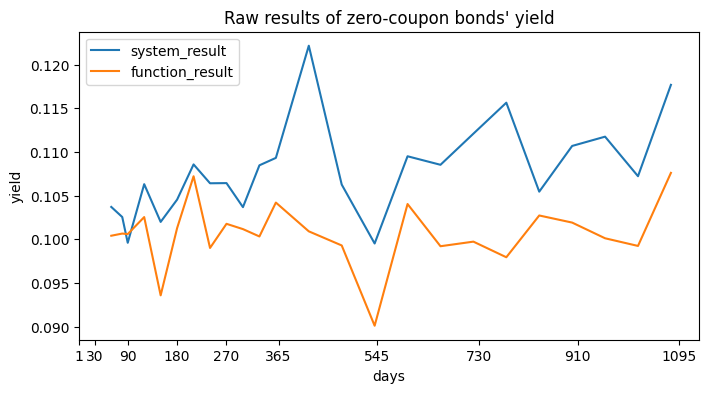

In [12]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .plot(figsize=(8,4), 
          title='Raw results of zero-coupon bonds\' yield',
          ylabel='yield', 
          xlabel='days', 
          xticks=[1, 30, 90, 180, 270, 365, 365+180, 365* 2, 365*2 + 180, 365*3])

<Axes: title={'center': "Rolled results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

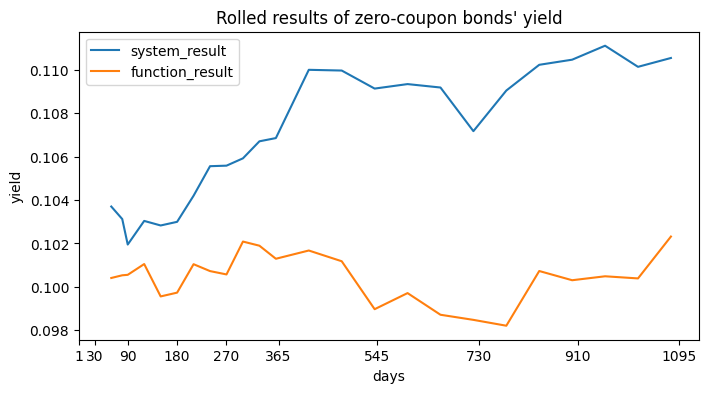

In [13]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()\
    .plot(figsize=(8,4), 
          title='Rolled results of zero-coupon bonds\' yield', 
          ylabel='yield', 
          xlabel='days', 
          xticks=[1, 30, 90, 180, 270, 365, 365+180, 365* 2, 365*2 + 180, 365*3])

<Axes: title={'center': "Rolled & avereged results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

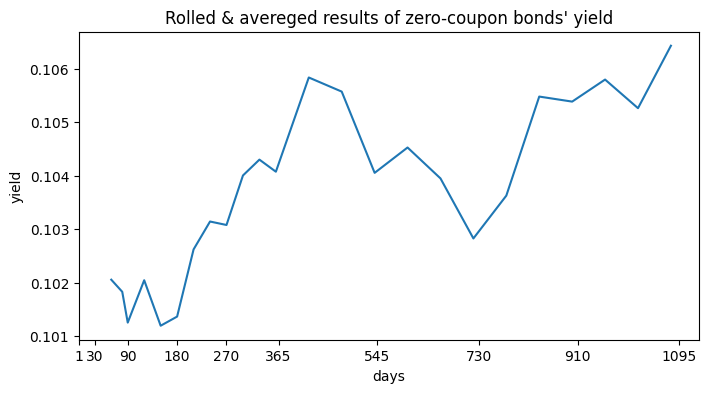

In [14]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .mean(axis=1)\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()\
    .plot(figsize=(8,4), 
          title='Rolled & avereged results of zero-coupon bonds\' yield', 
          ylabel='yield', 
          xlabel='days', 
          xticks=[1, 30, 90, 180, 270, 365, 365+180, 365* 2, 365*2 + 180, 365*3])

/home/vlad/all/stack/fin_venv/lib64/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Axes: title={'center': "Bootstrapped & rolled & avereged results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

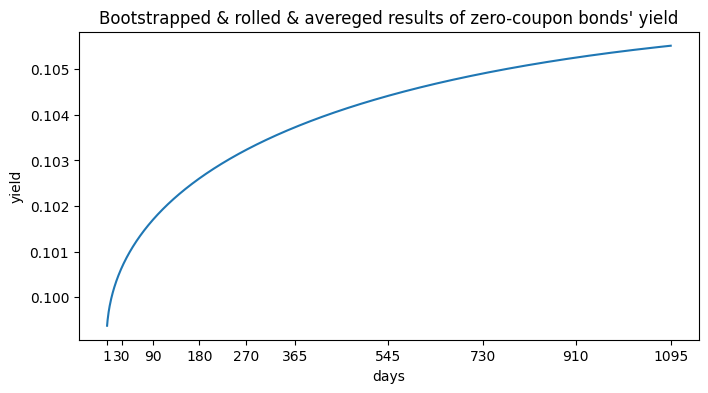

In [15]:
raw_result = general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .mean(axis=1)\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()


X = raw_result.reset_index()['index'].agg([lambda x: x, lambda x: x ** (1/2)])
y = raw_result.values
reg = LinearRegression().fit(X, y)

timeframe = np.arange(1, 365*3)
end_result = reg.predict(pd.DataFrame([timeframe, timeframe ** (1/2)]).T)

pd.DataFrame(end_result, index=timeframe)\
    [0]\
    .plot(figsize=(8,4), 
          title='Bootstrapped & rolled & avereged results of zero-coupon bonds\' yield', 
          ylabel='yield', 
          xlabel='days', 
          xticks=[1, 30, 90, 180, 270, 365, 365+180, 365* 2, 365*2 + 180, 365*3])